In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和风格
plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Arial Unicode MS']  # Mac常用中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

In [11]:
# --- 模拟数据生成 ---
np.random.seed(42)

# 图1: 收益率总体走势 (左图)
# 使用更真实的国债收益率走势：长期下行趋势 + 周期性波动
dates_1 = pd.date_range(start='2015-01-05', end='2025-01-05', freq='D')
n = len(dates_1)

# 长期下行趋势
long_term_trend = 4.5 - (np.arange(n) / n) * 2.5
# 周期性波动
cyclical = np.sin(np.linspace(0, 8*np.pi, n)) * 0.5
# 噪声
noise = np.random.normal(0, 0.1, n)

gov_bond_yield = long_term_trend + cyclical + noise
gov_bond_yield = np.clip(gov_bond_yield, 1.5, 5.0)

# AAA公司债和国开债基于国债加利差
aaa_corp_yield = gov_bond_yield + 0.8 + np.random.normal(0, 0.05, n)
policy_bond_yield = gov_bond_yield + 0.2 + np.random.normal(0, 0.03, n)

df_yield_trend = pd.DataFrame({
    'date': dates_1,
    '10年期国债': gov_bond_yield,
    '10年期AAA公司债': aaa_corp_yield,
    '10年期国开债': policy_bond_yield
})

# 图1: 收益率曲线 (右图) - 截至2025年9月30日
# 使用更标准的向上倾斜的收益率曲线
maturities = np.array([0.5, 1, 2, 3, 5, 7, 10, 15, 20, 30])
# 国债曲线
gov_curve = 1.5 + 1.2 * (1 - np.exp(-maturities / 5))
# 国开债和公司债在国债基础上加固定利差
policy_curve = gov_curve + 0.2
aaa_corp_curve = gov_curve + 0.8

df_yield_curve = pd.DataFrame({
    '期限(年)': maturities,
    '国债': gov_curve,
    '国开债': policy_curve,
    'AAA级公司债': aaa_corp_curve
})

# 图2: 流动性和收益率 (左图)
dates_2 = pd.date_range(start='2015-01-01', end='2025-01-01', freq='MS') # 'MS' for month start
n2 = len(dates_2)

# 银行间利率：波动较大，与政策利率相关
interbank_7d = 2.8 + np.sin(np.linspace(0, 6*np.pi, n2)) * 1.0 + np.random.normal(0, 0.2, n2)
interbank_7d = np.clip(interbank_7d, 1.0, 5.0)

# 同业存单：略高于银行间利率
deposit_1y = interbank_7d + 0.3 + np.random.normal(0, 0.1, n2)
deposit_1y = np.clip(deposit_1y, 1.5, 5.5)

# 10年期国债：与上面的长期趋势一致，但为月度数据
long_term_trend_2 = 4.5 - (np.arange(n2) / n2) * 2.5
cyclical_2 = np.sin(np.linspace(0, 8*np.pi, n2)) * 0.5
noise_2 = np.random.normal(0, 0.1, n2)
gov_bond_10y_2 = long_term_trend_2 + cyclical_2 + noise_2
gov_bond_10y_2 = np.clip(gov_bond_10y_2, 1.5, 5.0)

df_liquidity = pd.DataFrame({
    'date': dates_2,
    '7天银行间同业拆借': interbank_7d,
    '1年期AAA同业存单': deposit_1y,
    '10年期国债': gov_bond_10y_2
})

# 图2: 利率供需缺口 (右图)
dates_3 = pd.date_range(start='2017-01-01', end='2025-01-01', freq='MS')
n3 = len(dates_3)

# 社融-M2缺口：假设它与经济周期相关，与长端利率负相关
supply_demand_gap = 2.0 + np.sin(np.linspace(0, 6*np.pi, n3)) * 2.5 + np.random.normal(0, 0.3, n3)
supply_demand_gap = np.clip(supply_demand_gap, -3, 6)

# 10年期国债收益率（与缺口负相关）
gov_bond_10y_3 = 3.5 - 0.3 * supply_demand_gap + np.random.normal(0, 0.1, n3)
gov_bond_10y_3 = np.clip(gov_bond_10y_3, 1.5, 4.5)

df_supply_demand = pd.DataFrame({
    'date': dates_3,
    '社融存量同比 - M2同比': supply_demand_gap,
    '10年期国债收益率': gov_bond_10y_3
})

# 图3: 股债相关性
dates_4 = pd.date_range(start='2005-01-03', end='2025-01-03', freq='W')
n4 = len(dates_4)

# 相关系数：长期在0附近波动，有时为正有时为负
corr_coef = np.sin(np.linspace(0, 10*np.pi, n4)) * 0.3 + np.random.normal(0, 0.1, n4)
corr_coef = np.clip(corr_coef, -0.8, 0.7)

df_corr = pd.DataFrame({
    'date': dates_4,
    '股债表现相关系数': corr_coef
})

# 图4: 主要板块表现 (热力图数据)
years = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '25年初至今']
categories = [
    '可转债', '政金债', '金融债', '离岸投资等级债', '国债', '中国综合债券', '中高信用债',
    '中低信用债', '离岸高收益债', '离岸地产高收益', '全球债'
]

# 手动设定一些更符合现实的回报数据
returns_data = np.array([
    [56.9,  8.5,  9.2,  7.8, 11.2, 10.5,  9.8, 10.2, 12.5, 15.0,  6.5], # 2014
    [35.6,  8.2,  8.8,  7.5, 10.8, 10.2,  9.5,  9.8, 11.8, 14.2,  6.2], # 2015
    [ 2.3,  4.5,  5.1,  4.8,  5.2,  5.0,  4.7,  5.0,  6.5,  8.0,  3.5], # 2016
    [ 1.8,  4.2,  4.8,  4.5,  4.9,  4.7,  4.4,  4.7,  6.0,  7.5,  3.2], # 2017
    [ 1.5,  4.0,  4.6,  4.3,  4.7,  4.5,  4.2,  4.5,  5.8,  7.2,  3.0], # 2018
    [ 3.2,  5.0,  5.6,  5.3,  5.7,  5.5,  5.2,  5.5,  7.0,  8.5,  4.0], # 2019
    [ 5.8,  7.5,  8.1,  7.8,  8.2,  8.0,  7.7,  8.0,  9.5, 11.0,  5.5], # 2020
    [18.5,  6.2,  6.8,  6.5,  6.9,  6.7,  6.4,  6.7,  8.2,  9.7,  4.8], # 2021
    [-1.2,  3.8,  4.4,  4.1,  4.5,  4.3,  4.0,  4.3,  5.8,  7.3,  2.8], # 2022
    [-0.5,  3.5,  4.1,  3.8,  4.2,  4.0,  3.7,  4.0,  5.5,  7.0,  2.5], # 2023
    [42.3,  5.5,  6.1,  5.8,  6.2,  6.0,  5.7,  6.0,  7.5,  9.0,  4.5], # 2024
    [17.1,  2.0,  2.6,  2.3,  2.7,  2.5,  2.2,  2.5,  4.0,  5.5,  1.5]  # 25年初至今
])

# 波动率数据 (最后一列)
volatility_data = np.array([9.6, 2.2, 2.5, 3.8, 2.5, 2.8, 3.2, 4.5, 12.5, 20.5, 5.2])

df_performance = pd.DataFrame(returns_data, index=years, columns=categories)
df_volatility = pd.Series(volatility_data, index=categories, name='波动率(%)')

# 图5: 主要板块估值
categories_valuation = [
    '国债', '中国综合债券', '政金债', '金融债', '中高信用债', '中低信用债',
    '城投债', '离岸投资等级债', '离岸高收益债'
]

# 模拟最新、近10年均值、近10年区间，使其更符合现实
latest_yields = [1.72, 1.95, 1.85, 1.85, 2.23, 2.43, 1.98, 4.45, 7.63]
mean_yields = [2.83, 3.27, 2.55, 3.10, 3.99, 5.20, 2.61, 4.08, 11.78]
min_max_ranges = [(1.5, 4.0), (1.7, 4.5), (1.6, 3.5), (1.7, 4.5), (2.0, 5.5), (2.2, 7.5), (1.8, 3.5), (3.0, 6.0), (5.0, 15.0)]

df_valuation = pd.DataFrame({
    '类别': categories_valuation,
    '最新': latest_yields,
    '近10年均值': mean_yields,
    '近10年最小值': [r[0] for r in min_max_ranges],
    '近10年最大值': [r[1] for r in min_max_ranges]
})


## 图1: 中国固定收益：收益率总体走势

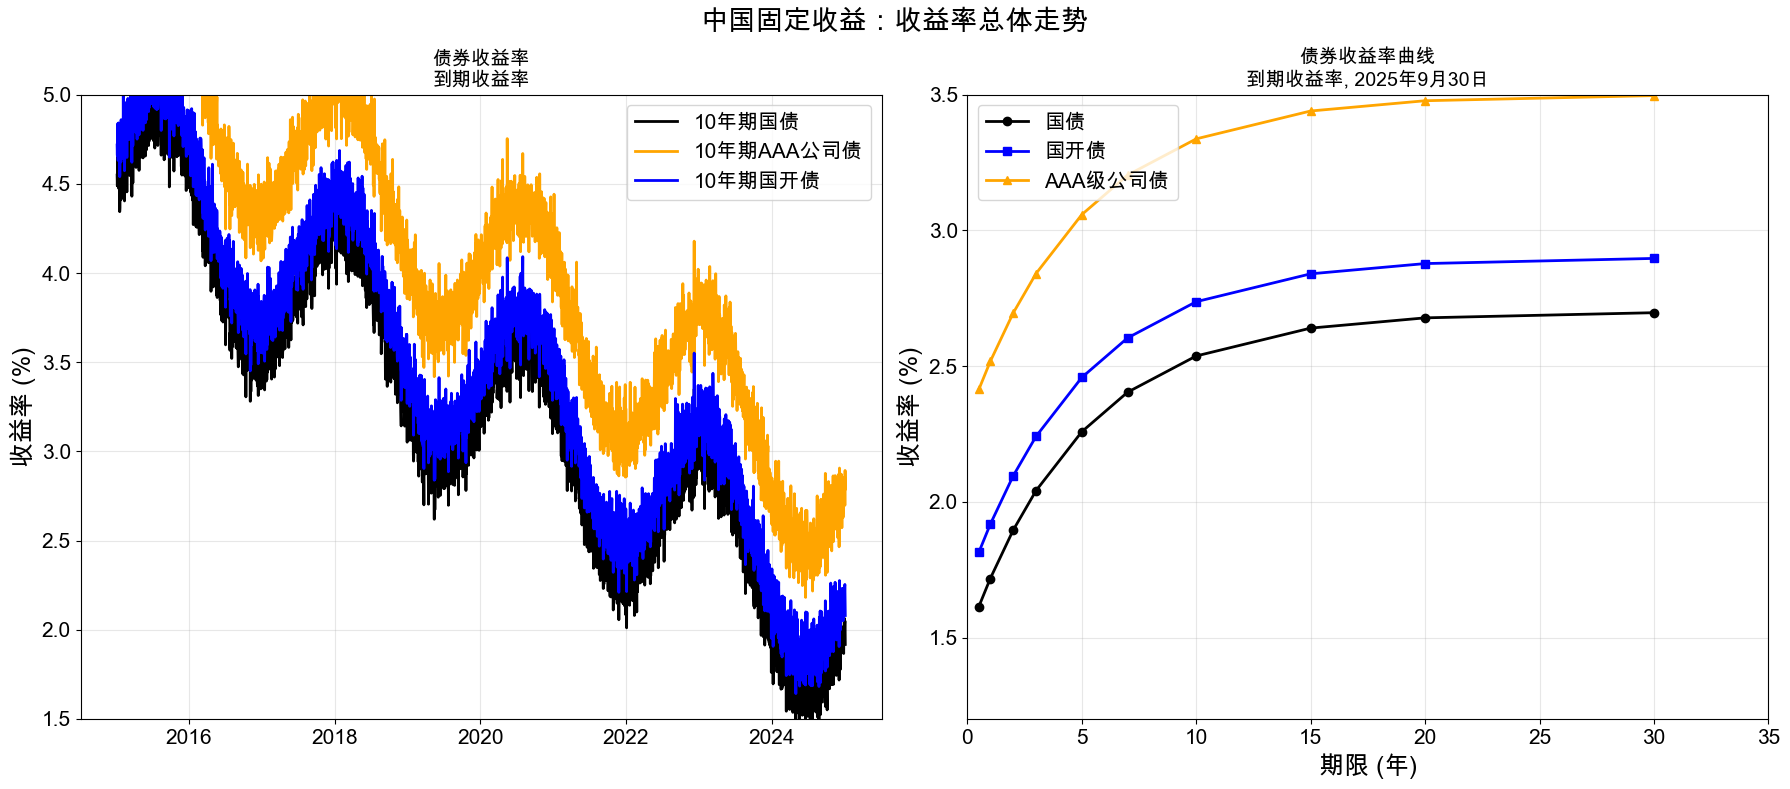

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 左图: 收益率走势
ax1 = axes[0]
ax1.plot(df_yield_trend['date'], df_yield_trend['10年期国债'], label='10年期国债', color='black', linewidth=2)
ax1.plot(df_yield_trend['date'], df_yield_trend['10年期AAA公司债'], label='10年期AAA公司债', color='orange', linewidth=2)
ax1.plot(df_yield_trend['date'], df_yield_trend['10年期国开债'], label='10年期国开债', color='blue', linewidth=2)
ax1.set_title('债券收益率\n到期收益率', fontsize=14, fontweight='bold')
ax1.set_ylabel('收益率 (%)')
ax1.set_ylim(1.5, 5.0)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')

# 右图: 收益率曲线
ax2 = axes[1]
ax2.plot(df_yield_curve['期限(年)'], df_yield_curve['国债'], label='国债', color='black', linewidth=2, marker='o')
ax2.plot(df_yield_curve['期限(年)'], df_yield_curve['国开债'], label='国开债', color='blue', linewidth=2, marker='s')
ax2.plot(df_yield_curve['期限(年)'], df_yield_curve['AAA级公司债'], label='AAA级公司债', color='orange', linewidth=2, marker='^')
ax2.set_title('债券收益率曲线\n到期收益率, 2025年9月30日', fontsize=14, fontweight='bold')
ax2.set_xlabel('期限 (年)')
ax2.set_ylabel('收益率 (%)')
ax2.set_ylim(1.2, 3.5)
ax2.set_xlim(0, 35)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')

plt.suptitle('中国固定收益：收益率总体走势', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

##  图2: 中国固定收益：流动性和收益率

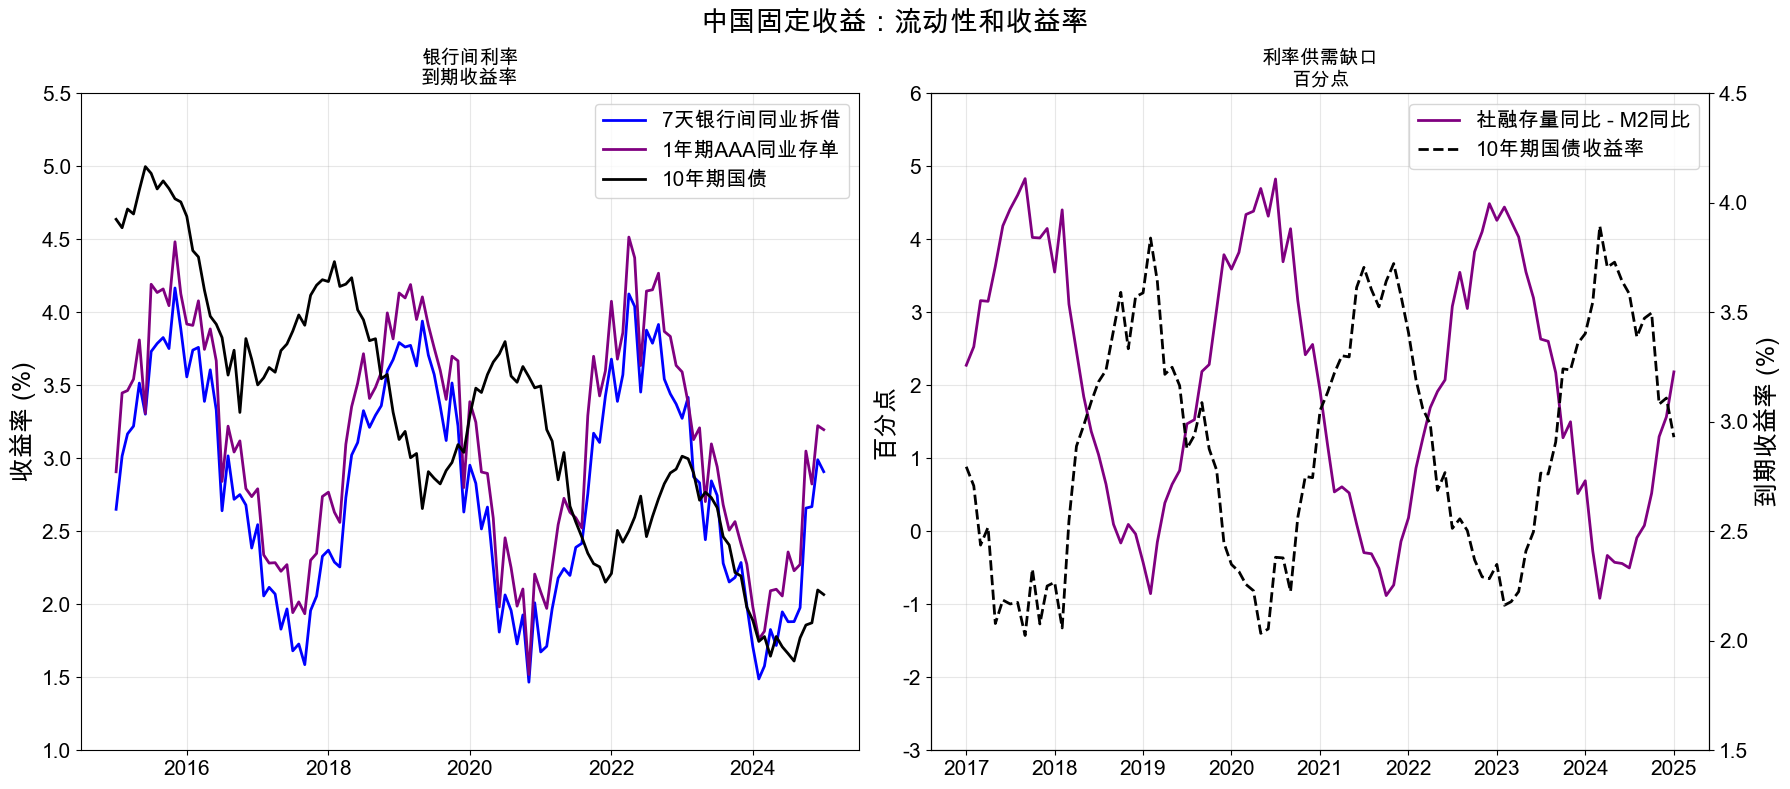

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 左图: 银行间利率
ax1 = axes[0]
ax1.plot(df_liquidity['date'], df_liquidity['7天银行间同业拆借'], label='7天银行间同业拆借', color='blue', linewidth=2)
ax1.plot(df_liquidity['date'], df_liquidity['1年期AAA同业存单'], label='1年期AAA同业存单', color='purple', linewidth=2)
ax1.plot(df_liquidity['date'], df_liquidity['10年期国债'], label='10年期国债', color='black', linewidth=2)
ax1.set_title('银行间利率\n到期收益率', fontsize=14, fontweight='bold')
ax1.set_ylabel('收益率 (%)')
ax1.set_ylim(1.0, 5.5)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')

# 右图: 利率供需缺口
ax2 = axes[1]
ax2.plot(df_supply_demand['date'], df_supply_demand['社融存量同比 - M2同比'], label='社融存量同比 - M2同比', color='purple', linewidth=2)
ax2.set_title('利率供需缺口\n百分点', fontsize=14, fontweight='bold')
ax2.set_ylabel('百分点')
ax2.set_ylim(-3, 6)
ax2.grid(True, alpha=0.3)

# 右侧Y轴
ax2_right = ax2.twinx()
ax2_right.plot(df_supply_demand['date'], df_supply_demand['10年期国债收益率'], label='10年期国债收益率', color='black', linewidth=2, linestyle='--')
ax2_right.set_ylabel('到期收益率 (%)')
ax2_right.set_ylim(1.5, 4.5)

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_right.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.suptitle('中国固定收益：流动性和收益率', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

## 图3: 中国固定收益：股债相关性

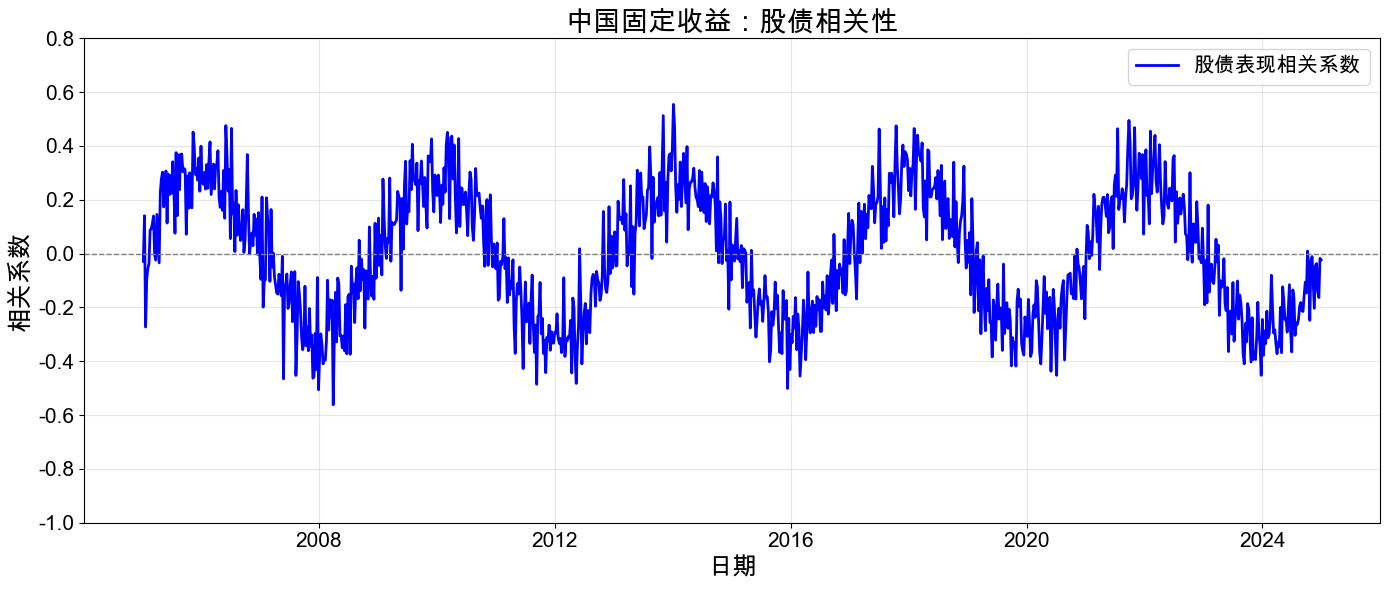

In [14]:
plt.figure(figsize=(14, 6))
plt.plot(df_corr['date'], df_corr['股债表现相关系数'], label='股债表现相关系数', color='blue', linewidth=2)
plt.title('中国固定收益：股债相关性', fontsize=20, fontweight='bold')
plt.ylabel('相关系数')
plt.xlabel('日期')
plt.ylim(-1.0, 0.8)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## 图4: 中国固定收益：主要板块表现 (热力图)

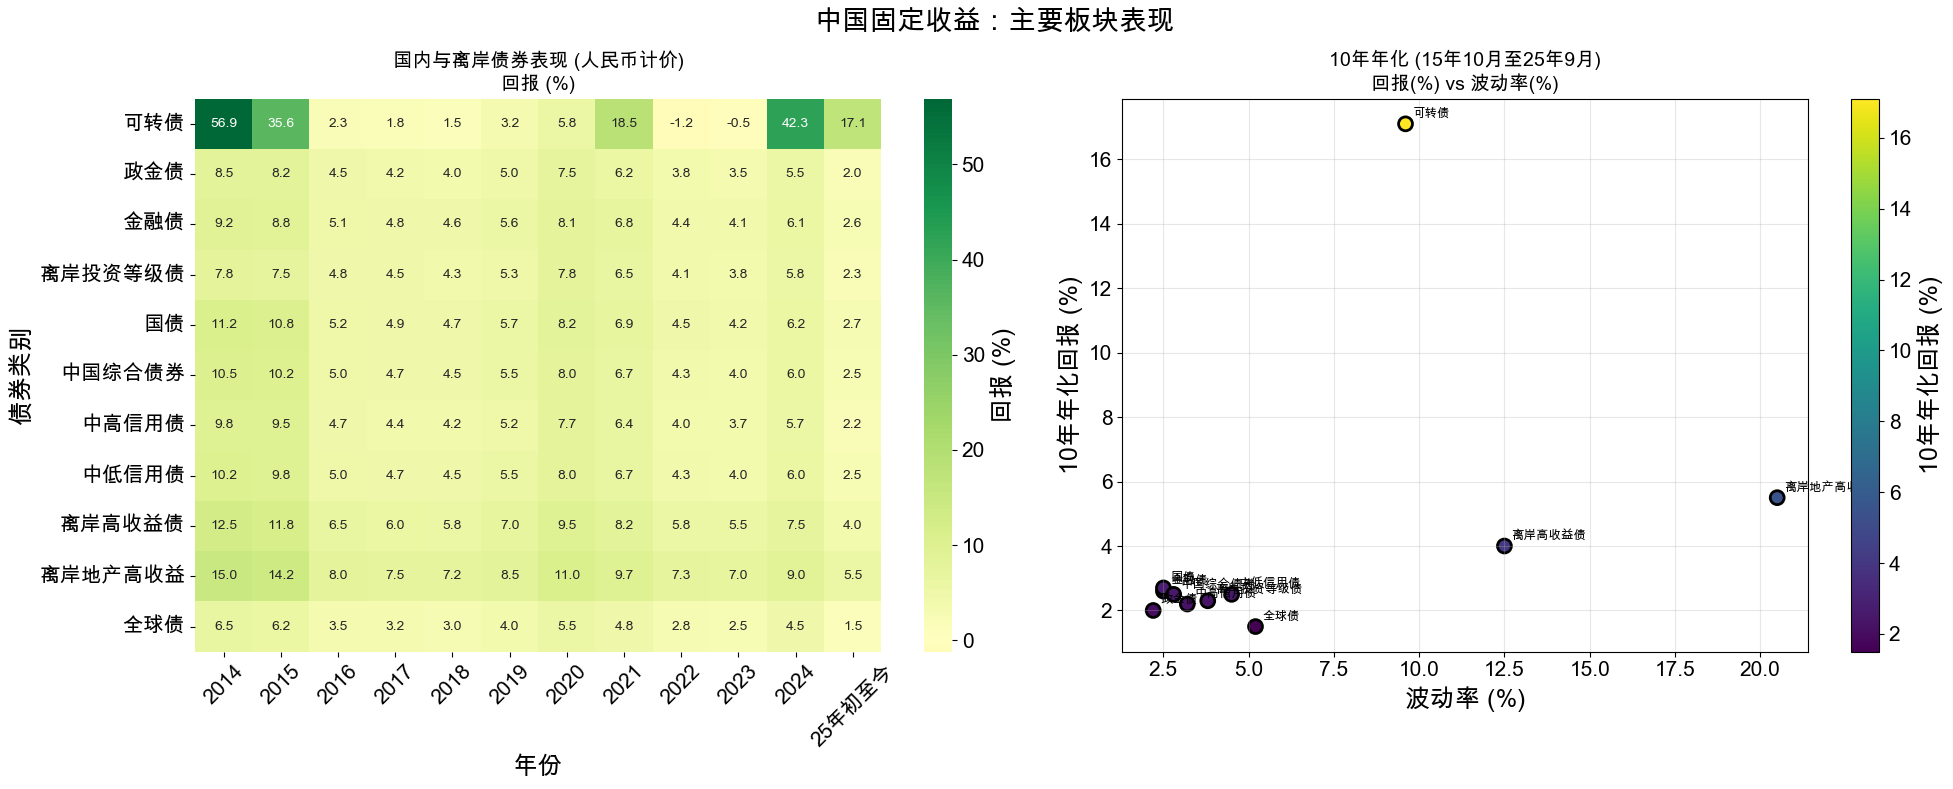

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 左图: 回报热力图
ax1 = axes[0]
sns.heatmap(df_performance.T, annot=True, fmt=".1f", cmap="RdYlGn", center=0, cbar_kws={'label': '回报 (%)'}, ax=ax1)
ax1.set_title('国内与离岸债券表现 (人民币计价)\n回报 (%)', fontsize=14, fontweight='bold')
ax1.set_xlabel('年份')
ax1.set_ylabel('债券类别')
ax1.tick_params(axis='x', rotation=45)

# 右图: 10年年化回报与波动率
ax2 = axes[1]
# 构建一个包含年化回报和波动率的数据框
# 这里我们假设“10年年化”是最后两列的平均值（仅为演示）
annualized_returns = df_performance.loc[['25年初至今']].T.mean(axis=1) # 简化处理
df_annual_vol = pd.DataFrame({
    '10年年化回报(%)': annualized_returns.values,
    '波动率(%)': df_volatility.values
}, index=annualized_returns.index)

# 绘制散点图
scatter = ax2.scatter(df_annual_vol['波动率(%)'], df_annual_vol['10年年化回报(%)'], 
                      s=100, c=df_annual_vol['10年年化回报(%)'], cmap='viridis', edgecolors='k', linewidth=2)

# 添加标签
for i, txt in enumerate(df_annual_vol.index):
    ax2.annotate(txt, (df_annual_vol['波动率(%)'][i], df_annual_vol['10年年化回报(%)'][i]), 
                 xytext=(5, 5), textcoords='offset points', fontsize=9)

ax2.set_title('10年年化 (15年10月至25年9月)\n回报(%) vs 波动率(%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('波动率 (%)')
ax2.set_ylabel('10年年化回报 (%)')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='10年年化回报 (%)')

plt.suptitle('中国固定收益：主要板块表现', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

## 图5: 中国固定收益：主要板块估值

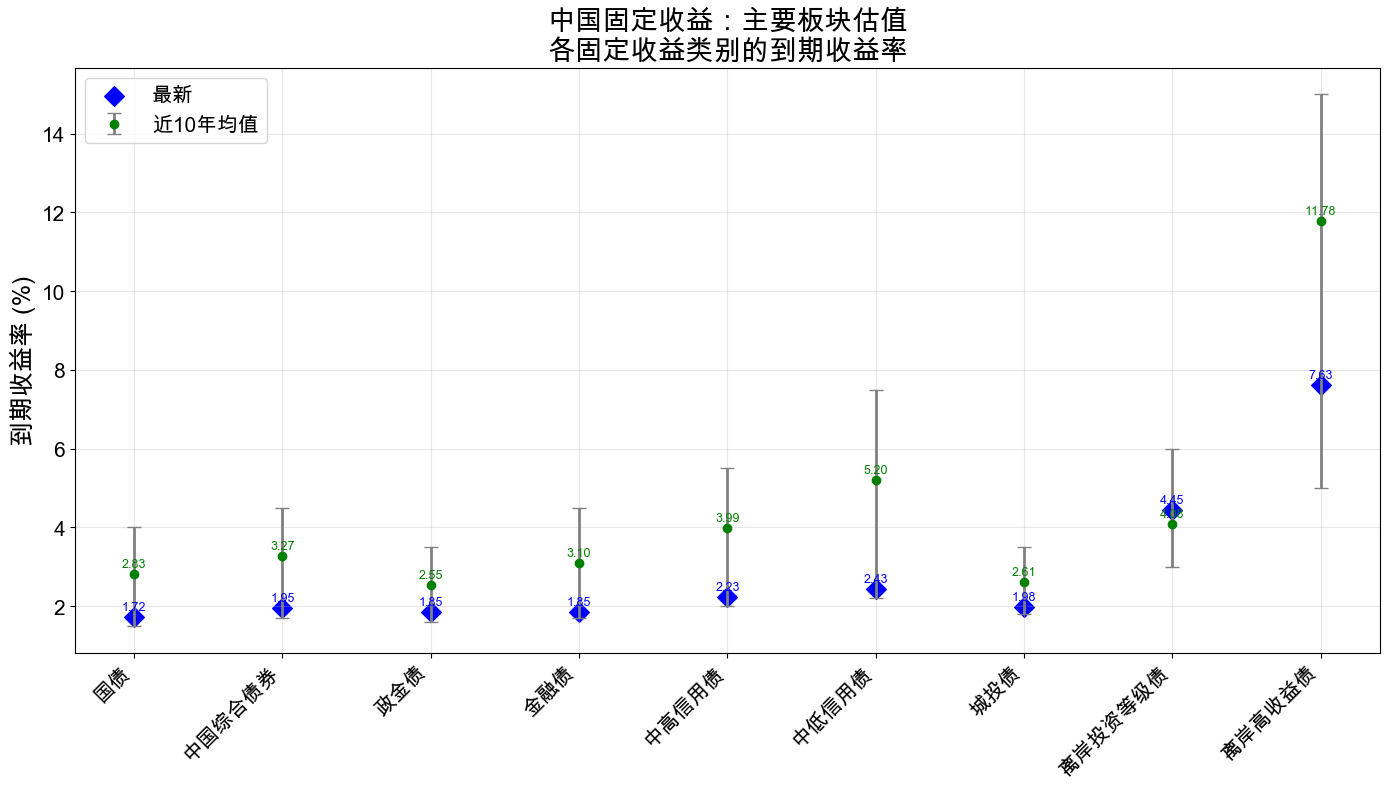

In [17]:
plt.figure(figsize=(14, 8))

# 使用误差棒图
y_pos = np.arange(len(df_valuation))

# 绘制近10年均值 (绿色横线)
plt.errorbar(y_pos, df_valuation['近10年均值'], xerr=None, yerr=[df_valuation['近10年均值'] - df_valuation['近10年最小值'],
                                                                 df_valuation['近10年最大值'] - df_valuation['近10年均值']],
             fmt='o', ecolor='gray', elinewidth=2, capsize=5, color='green', label='近10年均值')

# 绘制最新值 (蓝色菱形)
plt.scatter(y_pos, df_valuation['最新'], marker='D', s=100, color='blue', label='最新')

# 标注数值
for i, (cat, val) in enumerate(zip(df_valuation['类别'], df_valuation['最新'])):
    plt.text(i, val + 0.1, f'{val:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

for i, (cat, val) in enumerate(zip(df_valuation['类别'], df_valuation['近10年均值'])):
    plt.text(i, val + 0.1, f'{val:.2f}', ha='center', va='bottom', fontsize=9, color='green')

plt.xticks(y_pos, df_valuation['类别'], rotation=45, ha='right')
plt.ylabel('到期收益率 (%)')
plt.title('中国固定收益：主要板块估值\n各固定收益类别的到期收益率', fontsize=20, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# --- 生成综合性分析报告 ---
def generate_comprehensive_report(df_valuation, df_yield_trend, df_supply_demand, df_yield_curve):
    report = "=== 中国固定收益市场综合性分析报告 ===\n"
    report += f"报告日期: {datetime.now().strftime('%Y年%m月%d日')}\n\n"

    # 1. 市场概览
    report += "1. 市场概览\n"
    current_gov_yield = df_valuation[df_valuation['类别'] == '国债']['最新'].iloc[0]
    current_aaa_spread = df_valuation[df_valuation['类别'] == '中高信用债']['最新'].iloc[0] - current_gov_yield
    curve_steepness = df_yield_curve['国债'].iloc[-1] - df_yield_curve['国债'].iloc[0]
    recent_gap = df_supply_demand['社融存量同比 - M2同比'].iloc[-1]
    report += f"   - 当前10年期国债收益率: {current_gov_yield:.2f}%\n"
    report += f"   - 当前信用利差 (中高信用债 vs 国债): {current_aaa_spread:.2f}%\n"
    report += f"   - 收益率曲线陡峭度 (30Y-6M): {curve_steepness:.2f}%\n"
    report += f"   - 最近利率供需缺口: {recent_gap:.2f} 百分点\n\n"

    # 2. 关键指标评估
    report += "2. 关键指标评估\n"
    
    # 市场环境
    rate_trend_score = max(1, min(5, 5 - (current_gov_yield - 1.5) / (5.0 - 1.5) * 4))
    liquidity_score = max(1, min(5, 5 - abs(recent_gap) / 6 * 4))
    curve_score = 5 if curve_steepness > 1.0 else 3 if curve_steepness > 0.5 else 1
    
    # 风险收益
    credit_spread_ratio = current_aaa_spread / (3.99 - 2.83)
    credit_spread_score = 5 if credit_spread_ratio < 1.0 else 3 if credit_spread_ratio < 1.5 else 1
    vol_score = 5 if df_volatility['中高信用债'] < 5 else 3 if df_volatility['中高信用债'] < 10 else 1
    return_score = 5 if df_performance.loc['25年初至今', '中高信用债'] > 3 else 3 if df_performance.loc['25年初至今', '中高信用债'] > 2 else 1
    
    # 估值水平
    relative_val_score = 5 if current_gov_yield / 2.83 < 0.7 else 3 if current_gov_yield / 2.83 < 0.9 else 1
    absolute_val_score = 5 if current_gov_yield > 3 else 3 if current_gov_yield > 2 else 1
    
    report += f"   市场环境评分:\n"
    report += f"      - 利率趋势: {rate_trend_score:.1f}/5.0\n"
    report += f"      - 流动性: {liquidity_score:.1f}/5.0\n"
    report += f"      - 曲线形态: {curve_score:.1f}/5.0\n"
    report += f"   风险收益评分:\n"
    report += f"      - 信用利差: {credit_spread_score:.1f}/5.0\n"
    report += f"      - 波动率: {vol_score:.1f}/5.0\n"
    report += f"      - 年化回报: {return_score:.1f}/5.0\n"
    report += f"   估值水平评分:\n"
    report += f"      - 相对估值: {relative_val_score:.1f}/5.0\n"
    report += f"      - 绝对估值: {absolute_val_score:.1f}/5.0\n\n"

    # 3. 板块分析
    report += "3. 主要板块分析\n"
    for idx, row in df_valuation.iterrows():
        category = row['类别']
        latest = row['最新']
        mean = row['近10年均值']
        ratio = latest / mean if mean != 0 else 0
        status = "低估" if ratio > 1.1 else "高估" if ratio < 0.9 else "合理"
        report += f"   - {category}: 当前收益率 {latest:.2f}%，历史均值 {mean:.2f}%，估值状态: {status}。\n"
    
    # 4. 结论与建议
    report += "\n4. 结论与建议\n"
    overall_score = (rate_trend_score + liquidity_score + curve_score + 
                    credit_spread_score + vol_score + return_score + 
                    relative_val_score + absolute_val_score) / 8
    
    if overall_score > 3.5:
        conclusion = "市场整体环境较好，流动性充裕，收益率曲线陡峭，部分板块估值合理，适合配置。"
    elif overall_score > 2.5:
        conclusion = "市场环境一般，需精选板块，关注信用利差和估值水平，注意控制风险。"
    else:
        conclusion = "市场环境不佳，收益率偏低，估值偏高，建议保持谨慎，降低仓位或转向防御性资产。"
    
    report += f"   - 综合评分: {overall_score:.2f}/5.0\n"
    report += f"   - 结论: {conclusion}\n"
    report += "   - 建议: \n"
    report += "       1. 对于风险偏好较低的投资者，可配置国债、政金债等利率债。\n"
    report += "       2. 对于风险偏好较高的投资者，可关注离岸高收益债等高收益板块，但需承担相应波动风险。\n"
    report += "       3. 密切关注央行货币政策和社融数据变化，及时调整投资策略。\n"

    return report

# 生成报告
comprehensive_report = generate_comprehensive_report(df_valuation, df_yield_trend, df_supply_demand, df_yield_curve)
print(comprehensive_report)

=== 中国固定收益市场综合性分析报告 ===
报告日期: 2025年10月17日

1. 市场概览
   - 当前10年期国债收益率: 1.72%
   - 当前信用利差 (中高信用债 vs 国债): 0.51%
   - 收益率曲线陡峭度 (30Y-6M): 1.08%
   - 最近利率供需缺口: 2.18 百分点

2. 关键指标评估
   市场环境评分:
      - 利率趋势: 4.7/5.0
      - 流动性: 3.5/5.0
      - 曲线形态: 5.0/5.0
   风险收益评分:
      - 信用利差: 5.0/5.0
      - 波动率: 5.0/5.0
      - 年化回报: 3.0/5.0
   估值水平评分:
      - 相对估值: 5.0/5.0
      - 绝对估值: 1.0/5.0

3. 主要板块分析
   - 国债: 当前收益率 1.72%，历史均值 2.83%，估值状态: 高估。
   - 中国综合债券: 当前收益率 1.95%，历史均值 3.27%，估值状态: 高估。
   - 政金债: 当前收益率 1.85%，历史均值 2.55%，估值状态: 高估。
   - 金融债: 当前收益率 1.85%，历史均值 3.10%，估值状态: 高估。
   - 中高信用债: 当前收益率 2.23%，历史均值 3.99%，估值状态: 高估。
   - 中低信用债: 当前收益率 2.43%，历史均值 5.20%，估值状态: 高估。
   - 城投债: 当前收益率 1.98%，历史均值 2.61%，估值状态: 高估。
   - 离岸投资等级债: 当前收益率 4.45%，历史均值 4.08%，估值状态: 合理。
   - 离岸高收益债: 当前收益率 7.63%，历史均值 11.78%，估值状态: 高估。

4. 结论与建议
   - 综合评分: 4.04/5.0
   - 结论: 市场整体环境较好，流动性充裕，收益率曲线陡峭，部分板块估值合理，适合配置。
   - 建议: 
       1. 对于风险偏好较低的投资者，可配置国债、政金债等利率债。
       2. 对于风险偏好较高的投资者，可关注离岸高收益债等高收益板块，但需承担相应波动风险。
       3. 密切关注央行货币政策和社融数据变化，及时调整